In [43]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np
import scipy.integrate as integrate
import scipy.special as special
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import chain
from scipy.optimize import fmin

import warnings
warnings.filterwarnings("ignore")
import os
if not os.path.exists('plots/'):
    os.mkdir('plots')
if not os.path.exists('data_saved/'):
    os.mkdir('data_saved')
if not os.path.exists('data_saved/Direct_sub/'):
    os.mkdir('data_saved/Direct_sub')  

    
def data_save(filename, Xdata, Ydata):
    combined_data = [ Xdata, Ydata]
    combined_data = [[row[i] for row in combined_data] for i in range(len(combined_data[0]))]
    filename_saving= ('data_saved/Direct_sub/'+filename+'.txt')
    with open(filename_saving, 'w+') as output_file:
        np.savetxt(output_file, combined_data,fmt='%.14e')
    output_file.close()    

In [44]:
# Experimental data for NaCl MIC
NaCl_initial = [ 0.5 ,1.0, 1.5, 2.0, 2.5] 
NaCl_M = [i*0.1 for i in NaCl_initial]
NaCl_mM = [i*100 for i in NaCl_initial]
MIC_NaCl = [ 1.12, 1.25, 1.62 ,1.75, 2 ] #units µM

# Convert NaCl concentration to kappa length
def m_mol_to_kappa(mol):
    Molar = mol * 10**(-3)  # mili Mol to Mol
    kappa = 0.304/np.sqrt(Molar)*10 #Length unit in amstrong
    return 1/ kappa
kappa_range = [m_mol_to_kappa(mol) for mol in NaCl_mM ]


In [45]:
# Define variables 
Eps         = 8.85e-12;               #Vacume permitivity (coloum^2/Jm)         
T           = 277;                    #Tempreture (kelvin)
Kb          = 1.38*1e-23;             #Boltzmann Constant (J/kelvin)
Dw          = 80;                     #Water dielectric constant
NA          = 6.023*1e+23;            #Avagadro's number
V           = 1e27;                   #Total volume in (A^3) 
ele         = 1.6e-19;                #Electron Charge
lb          = ele**2*1e+10/(4*np.pi*Eps*Dw*Kb*T);   #% Bjerrum Length (A)

# Peptide parameter defined 
Q = 6;      # Peptide charge for peptide LL-37
a0 = 71;   # Surface area per lipid
b = 4.1; # Twice the persistence length of melittin (length of one monomer amino acid) 
N = 37;  # number of amino acids (LL-37)



#  Compute Binding Energy Function

In [46]:
# Simplified electrostatic binding Energy 
# Direct Subsitution Method

def electrostatic_E(kappa):
    # F_el_s component: electrostatic free energy of a charged surface     
    sig_net= (Q/A1) -(f_A/a0)
    phi_0 = 2*  np.arcsinh((2*np.pi*lb*sig_net)/kappa)
    f_plate = (sig_net *phi_0)  -((kappa/(np.pi*lb))*(np.cosh(phi_0/2)-1))
    f_el_S = f_plate*A1

    # F_el_s_0 component: electrostatic free energy on unbound peptide states of [F_el_s]
    sig_0 = -(f_A/a0)
    phi_00 = 2* np.arcsinh((2*np.pi*lb*sig_0)/kappa)
    f_plate_0 = (sig_0 *phi_00 ) - ((kappa/(np.pi*lb))*(np.cosh(phi_00/2)-1))
    f_el_S_0 = f_plate_0*A1
    
    # F_el_L component: electrostatic self energy of a free ligand in solution 
    lambda2 = .126 # lambda2 = e^2/(4*eps*r0*kT)
    r0 = 15   #radius of the peptide ([A] Angstrom)
    lambda3 = kappa*r0
    f_el_L = (2*Q**2 *lambda2)/(1+lambda3)

    del_F = f_el_S - f_el_S_0 - f_el_L 
    return del_F



#  Compute Binding Energy

Wb range Outer =  [-11.11127841256015, -10.709673687364848, -10.497161633573358, -10.361157250219467, -10.26541687670721]
Wb range Inner =  [-8.681561978511274, -8.364839845237391, -8.195837259882541, -8.086788011224609, -8.009188733407877]


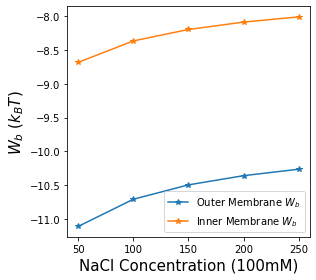

In [47]:
# Outer membrane
A1 = 194;  # n*alpha*f_0 : total area of lipid
f_A = 1;  # Fraction of anionic lipids
hydrophobic = -10 # Assuming that the hydrophobic energy being -10[kbT]
wb_range_outer =[]

for kappa in kappa_range:
    ele = electrostatic_E(kappa)
    bindingE = hydrophobic+ele 
    wb_range_outer.append(bindingE)

print('Wb range Outer = ',wb_range_outer)

    
# Inner membrane
A1 = 472;  # n*alpha*f_0 : total area of lipid
f_A = .4;  # Fraction of anionic lipids
hydrophobic = -7.25 # Assuming that the hydrophobic energy being -10[kbT]
wb_range_inner =[]

for kappa in kappa_range:
    ele = electrostatic_E(kappa)
    bindingE = hydrophobic+ele 
    wb_range_inner.append(bindingE)

print('Wb range Inner = ',wb_range_inner)



plt.figure(figsize=(4.5,4))
plt.plot(NaCl_mM,wb_range_outer,'-*',label='Outer Membrane $W_b$')
plt.plot(NaCl_mM,wb_range_inner,'-*',label='Inner Membrane $W_b$')
plt.xlabel('NaCl Concentration (100mM)' , fontsize = 15)
plt.ylabel('$W_b$ ($k_BT$)', fontsize = 15)
plt.legend()
plt.tight_layout()


# Mapping to Langmuir Model (Compute MIC)

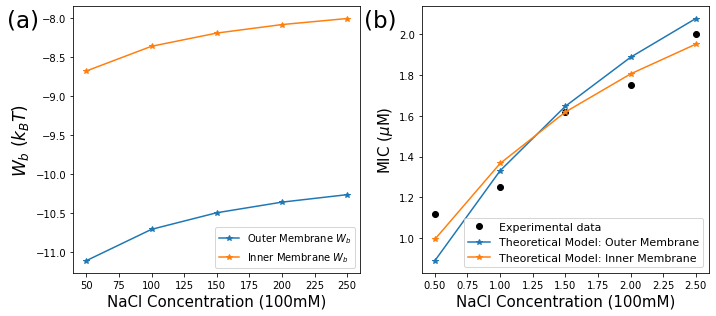

In [48]:
# Function defined for MIC and binding E 

w_B  = -16.6        #bacteria            # w_b = -16.6kbT
w_H  = -7.54      #host                # w_h = -6.72kbT
A_p = 400           #Amstrong square
v_p = 33**3         #Amstrong cube
A_B = 400           #Amstrong square (Surface area of each cells)
A_H = A_B        #Amstrong square
a_B = 71            #Amstrong square (Area of each lipids)
a_H = 74             #Angstrom square 
A_t = 12*10**8 #Ah and Ab
At = 12*10**8 #Ah and Ab


# Priminary Constant values
avo_con = 6.023*10**23 #Avogadro constant ==> 6.022 × 10^23 mol^(-1)
mu_M_unit = 10**-6*avo_con *10**-27
unit =10**-24 #(unit conversion)
PL_B_outer = 0.1 # Assuming binding energy -11.7kbT @kappa =0.1 (with MIC_0 =1.2[micro M])
PL_B_inner = 0.02 # Assuming binding energy -11.7kbT @kappa =0.1 (with MIC_0 =1.2[micro M])


def MIC_non_competitive_membrane(CB, w_B, PL_B):    

    MIC_0 = 1/v_p* A_B/a_B * PL_B /(1-  A_B/a_B * PL_B)*(np.exp(w_B))
    eq1   = (PL_B*At/a_B ) *CB*unit +  MIC_0
    Cp    = eq1/mu_M_unit    
    return Cp

# Mapping to Langmuir Model

plt.figure(figsize=(10,4.5))

ax1 = plt.subplot(1,2,1)
plt.plot(NaCl_mM,wb_range_outer,'-*',label='Outer Membrane $W_b$')
plt.plot(NaCl_mM,wb_range_inner,'-*',label='Inner Membrane $W_b$')
plt.legend()
plt.xlabel('NaCl Concentration (100mM)' , fontsize = 15)
plt.ylabel('$W_b$ $(k_B T)$',fontsize = 17)
plt.text(-0.23,.925,"(a)",fontsize=23, transform=ax1.transAxes)


ax2 = plt.subplot(1,2,2)
plt.plot(NaCl_initial,MIC_NaCl,'o',label='Experimental data',color ='k')
CB_range = [5*10**(3)]
CB = 5*10**(3)
# for CB in CB_range: 
MIC_values_outer=[]
MIC_values_inner=[]
for i, Wb_outer in enumerate(wb_range_outer): 
    Wb_inner = wb_range_inner[i]
    MIC_values_outer.append(MIC_non_competitive_membrane(CB,Wb_outer,PL_B_outer))
    MIC_values_inner.append(MIC_non_competitive_membrane(CB,Wb_inner,PL_B_inner))
plt.plot(NaCl_initial, MIC_values_outer,'-*',label='Theoretical Model: Outer Membrane')
plt.plot(NaCl_initial, MIC_values_inner,'-*',label='Theoretical Model: Inner Membrane')

    
plt.xlabel('NaCl Concentration (100mM)' , fontsize = 15)
plt.ylabel('MIC ($\mu$M)', fontsize = 15)
plt.legend(fontsize=11)

plt.text(-0.2,.925,"(b)",fontsize=23, transform=ax2.transAxes)


plt.tight_layout()
plt.savefig('plots/'+('Outer_layer_PL_01')+'.pdf',bbox_inches='tight')



# Save Data

In [49]:
# Binding E
filename1 = 'Outer_membrane_bindingE'
filename2 = 'Inner_membrane_bindingE'

data_save(filename1,NaCl_mM, wb_range_outer)
data_save(filename2,NaCl_mM, wb_range_inner)

# MIC
filename1 = 'Outer_membrane_MIC'
filename2 = 'Inner_membrane_MIC'
data_save(filename1,NaCl_mM, MIC_values_outer)
data_save(filename2,NaCl_mM, MIC_values_inner)

filename1 = 'Experimental_MIC'
data_save(filename1,NaCl_mM, MIC_NaCl)

